# Полносвязные нейронные сети

In [1]:
import collections
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import notebook

In [2]:
def build_fcnn(model_id, n_tier, n_features, use_batchnorm=False, p_dropout=None):
    torch.manual_seed(0)
    np.random.seed(0)

    layers = collections.OrderedDict()
    for i in range(n_tier):
        layers[f'linear{i}'] = nn.Linear(n_features, n_features)
        if use_batchnorm:
            layers[f'batchnorm{i}'] = nn.BatchNorm1d(n_features)
        layers[f'relu{i}'] = nn.ReLU(inplace=True)
        if p_dropout:
            layers[f'dropout{i}'] = nn.Dropout(p_dropout)
    
    layers[f'linear_out'] = nn.Linear(n_features, 1)

    net = nn.Sequential(layers)
    net.model_id = model_id
    return net


def batch_generator(X, Y, batch_size=24):
    for i in range(0, X.shape[0], batch_size):
        yield X[i:i+batch_size], Y[i:i+batch_size]


def train_model(model, n_epochs, n_early_stop, X_train, Y_train, X_val, Y_val, device, verbose=False, batch_size=24):
    model_state_dict_path = f'{model.model_id}.pth'
    best_val_loss = np.inf
    best_epoch = -1
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_func = nn.MSELoss()
    train_time_seconds = 0
    i = 0
    for epoch in notebook.tqdm(range(n_epochs)):
        start = time.time()
        model.train()
        sum_loss = 0
        n = 0
        for batch_x, batch_y in batch_generator(X_train, Y_train, batch_size):
            batch_x = torch.from_numpy(batch_x).to(device)
            batch_y = torch.from_numpy(batch_y).to(device)
            prediction = model(batch_x)

            loss = loss_func(prediction, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            sum_loss += loss * batch_x.size(0)
            n += batch_x.size(0)
        
        model.eval()
        with torch.no_grad():
            prediction = model(torch.from_numpy(X_val).to(device))
            val_loss = loss_func(prediction, torch.from_numpy(Y_val).to(device)).numpy()
        
        finish = time.time()
        train_time_seconds += finish - start

        if verbose:
            print('model_id:', model.model_id, 'epoch:', epoch, 'train_loss:', sum_loss.detach().numpy() / n, 'val_loss:', val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), model_state_dict_path)
            i = 0
        else:
            i += 1
            if i > n_early_stop:
                break
        
    return {'best_epoch': best_epoch, 'best_val_loss': best_val_loss.item(), 'model_state_dict_path': model_state_dict_path, 'train_time_seconds': train_time_seconds}


def features_target(data_frame):
    return data_frame[data_frame.columns[3:]].to_numpy(), data_frame['NumCases'].to_numpy()

## 1 Предсказания значений на следующий месяц по данным за предыдущий год

In [3]:
time_series = pd.read_csv('time_series.csv').astype('float32')
time_series.head()

,Year,Month,NumCases
0,1980.0,1.0,1825.0
1,1980.0,2.0,1730.0
2,1980.0,3.0,1743.0
3,1980.0,4.0,1760.0
4,1980.0,5.0,1863.0


In [4]:
for i in range(1, 13, 1):
    time_series[f'NumCases_{i}'] = time_series['NumCases'].shift(i)

In [5]:
time_series = time_series[12:]
time_series.head()

,Year,Month,NumCases,NumCases_1,NumCases_2,NumCases_3,NumCases_4,NumCases_5,NumCases_6,NumCases_7,NumCases_8,NumCases_9,NumCases_10,NumCases_11,NumCases_12
12,1981.0,1.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0,1730.0,1825.0
13,1981.0,2.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0,1730.0
14,1981.0,3.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0
15,1981.0,4.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0
16,1981.0,5.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0


In [6]:
test = time_series[-60:]
train = time_series[:-60]
val = train[-60:]
train = train[:-60]

train.shape, val.shape, test.shape

((288, 15), (60, 15), (60, 15))

In [7]:
X_train, Y_train = features_target(train)
X_val, Y_val = features_target(val)
X_test, Y_test = features_target(test)

In [8]:
scaler_x = sklearn.preprocessing.StandardScaler()
scaler_y = sklearn.preprocessing.StandardScaler()

X_train = scaler_x.fit_transform(X_train)
Y_train = scaler_y.fit_transform(Y_train.reshape(-1, 1))

X_val = scaler_x.transform(X_val)
Y_val = scaler_y.transform(Y_val.reshape(-1, 1))

X_test = scaler_x.transform(X_test)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 10000
N_EARLY_STOP = 1000

### 1.1 Двухслойные модели

In [10]:
fcnn_2_layers_no_batchnorm_no_dropout = build_fcnn('fcnn_2_layers_no_batchnorm_no_dropout', n_tier=1, n_features=12)
fcnn_2_layers_no_batchnorm_no_dropout

Sequential(
  (linear0): Linear(in_features=12, out_features=12, bias=True)
  (relu0): ReLU(inplace=True)
  (linear_out): Linear(in_features=12, out_features=1, bias=True)
)

In [11]:
train_model(fcnn_2_layers_no_batchnorm_no_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

{'best_epoch': 2092,
 'best_val_loss': 0.10251366347074509,
 'model_state_dict_path': 'fcnn_2_layers_no_batchnorm_no_dropout.pth',
 'train_time_seconds': 32.41977906227112}

In [12]:
fcnn_2_layers_batchnorm_no_dropout = build_fcnn('fcnn_2_layers_batchnorm_no_dropout', n_tier=1, n_features=12, use_batchnorm=True)
fcnn_2_layers_batchnorm_no_dropout

Sequential(
  (linear0): Linear(in_features=12, out_features=12, bias=True)
  (batchnorm0): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (linear_out): Linear(in_features=12, out_features=1, bias=True)
)

In [13]:
train_model(fcnn_2_layers_batchnorm_no_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

{'best_epoch': 72,
 'best_val_loss': 0.15864112973213196,
 'model_state_dict_path': 'fcnn_2_layers_batchnorm_no_dropout.pth',
 'train_time_seconds': 16.75825786590576}

In [14]:
fcnn_2_layers_no_batchnorm_dropout = build_fcnn('fcnn_2_layers_no_batchnorm_dropout', n_tier=1, n_features=12, use_batchnorm=False, p_dropout=0.5)
fcnn_2_layers_no_batchnorm_dropout

Sequential(
  (linear0): Linear(in_features=12, out_features=12, bias=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=12, out_features=1, bias=True)
)

In [15]:
train_model(fcnn_2_layers_no_batchnorm_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

{'best_epoch': 1519,
 'best_val_loss': 0.1179535835981369,
 'model_state_dict_path': 'fcnn_2_layers_no_batchnorm_dropout.pth',
 'train_time_seconds': 28.60511803627014}

In [16]:
fcnn_2_layers_batchnorm_dropout = build_fcnn('fcnn_2_layers_batchnorm_dropout', n_tier=1, n_features=12, use_batchnorm=True, p_dropout=0.5)
fcnn_2_layers_batchnorm_dropout

Sequential(
  (linear0): Linear(in_features=12, out_features=12, bias=True)
  (batchnorm0): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=12, out_features=1, bias=True)
)

In [17]:
train_model(fcnn_2_layers_batchnorm_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

{'best_epoch': 41,
 'best_val_loss': 0.19744552671909332,
 'model_state_dict_path': 'fcnn_2_layers_batchnorm_dropout.pth',
 'train_time_seconds': 17.340676069259644}

### 1.2 Трёхслойные модели

In [18]:
fcnn_3_layers_no_batchnorm_no_dropout = build_fcnn('fcnn_3_layers_no_batchnorm_no_dropout', n_tier=2, n_features=12)
print(fcnn_3_layers_no_batchnorm_no_dropout)
train_model(fcnn_3_layers_no_batchnorm_no_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=12, out_features=12, bias=True)
  (relu0): ReLU(inplace=True)
  (linear1): Linear(in_features=12, out_features=12, bias=True)
  (relu1): ReLU(inplace=True)
  (linear_out): Linear(in_features=12, out_features=1, bias=True)
)


{'best_epoch': 1642,
 'best_val_loss': 0.11353575438261032,
 'model_state_dict_path': 'fcnn_3_layers_no_batchnorm_no_dropout.pth',
 'train_time_seconds': 37.069236755371094}

In [19]:
fcnn_3_layers_batchnorm_no_dropout = build_fcnn('fcnn_3_layers_batchnorm_no_dropout', n_tier=2, n_features=12, use_batchnorm=True)
print(fcnn_3_layers_batchnorm_no_dropout)
train_model(fcnn_3_layers_batchnorm_no_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=12, out_features=12, bias=True)
  (batchnorm0): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (linear1): Linear(in_features=12, out_features=12, bias=True)
  (batchnorm1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (linear_out): Linear(in_features=12, out_features=1, bias=True)
)


{'best_epoch': 818,
 'best_val_loss': 0.23208311200141907,
 'model_state_dict_path': 'fcnn_3_layers_batchnorm_no_dropout.pth',
 'train_time_seconds': 44.965867042541504}

In [20]:
fcnn_3_layers_no_batchnorm_dropout = build_fcnn('fcnn_3_layers_no_batchnorm_dropout', n_tier=2, n_features=12, use_batchnorm=False, p_dropout=0.5)
print(fcnn_3_layers_no_batchnorm_dropout)
train_model(fcnn_3_layers_no_batchnorm_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=12, out_features=12, bias=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=12, out_features=12, bias=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=12, out_features=1, bias=True)
)


{'best_epoch': 2559,
 'best_val_loss': 0.1610182374715805,
 'model_state_dict_path': 'fcnn_3_layers_no_batchnorm_dropout.pth',
 'train_time_seconds': 57.41144847869873}

In [21]:
fcnn_3_layers_batchnorm_dropout = build_fcnn('fcnn_3_layers_batchnorm_dropout', n_tier=2, n_features=12, use_batchnorm=True, p_dropout=0.5)
print(fcnn_3_layers_batchnorm_dropout)
train_model(fcnn_3_layers_batchnorm_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=12, out_features=12, bias=True)
  (batchnorm0): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=12, out_features=12, bias=True)
  (batchnorm1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=12, out_features=1, bias=True)
)


{'best_epoch': 7649,
 'best_val_loss': 0.2764314115047455,
 'model_state_dict_path': 'fcnn_3_layers_batchnorm_dropout.pth',
 'train_time_seconds': 228.35610580444336}

### 1.3 Лучшая модель на данных за предыдущий года

In [22]:
best_model_12months = build_fcnn('fcnn_2_layers_no_batchnorm_no_dropout', n_tier=1, n_features=12).to(device)
best_model_12months.load_state_dict(torch.load('fcnn_2_layers_no_batchnorm_no_dropout.pth'))
best_model_12months.eval()

Sequential(
  (linear0): Linear(in_features=12, out_features=12, bias=True)
  (relu0): ReLU(inplace=True)
  (linear_out): Linear(in_features=12, out_features=1, bias=True)
)

In [23]:
with torch.no_grad():
    Y_predict_scaled = best_model_12months(torch.from_numpy(X_test).to(device)).numpy()

Y_predict = scaler_y.inverse_transform(Y_predict_scaled).squeeze()

In [24]:
print('RMSE:', sklearn.metrics.mean_squared_error(Y_test, Y_predict, squared=False))

RMSE: 70.164116


In [25]:
prediction = [np.nan] * time_series.shape[0]
prediction[-60:] = Y_predict
time_series['NumCases_predict'] = prediction
time_series['Date'] = time_series['Year'] + (time_series['Month'] - 1) / 12

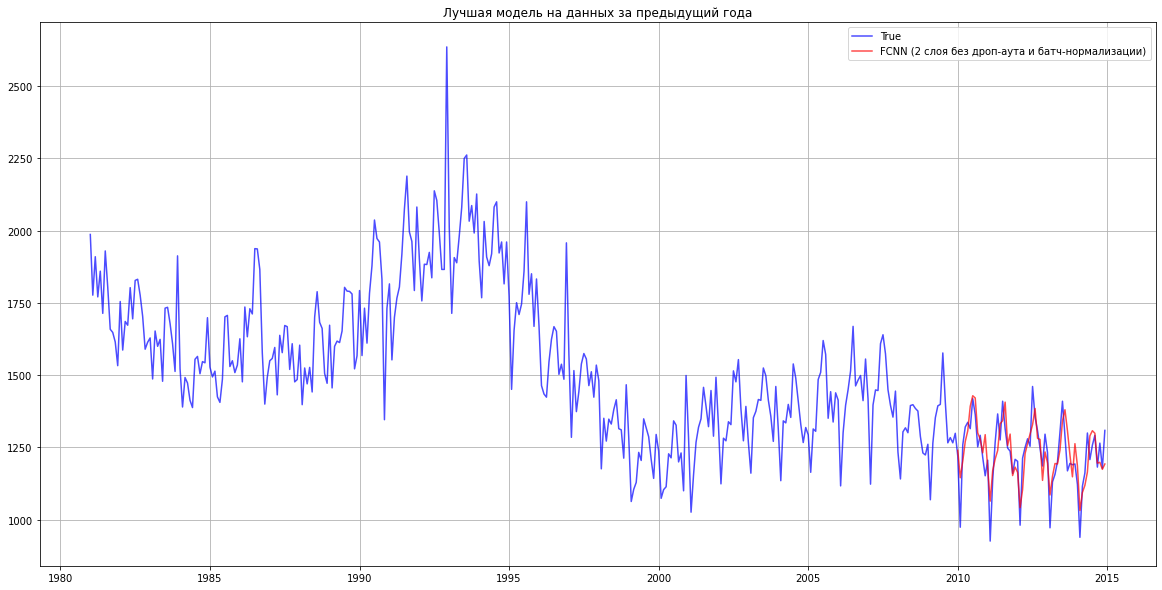

In [26]:
plt.figure(figsize=(20,10)) 
plt.plot(time_series['Date'], time_series['NumCases'], color='b', alpha=0.7, label="True")
plt.plot(time_series['Date'][-60:], time_series['NumCases_predict'][-60:], color='r', alpha=0.7, label="FCNN (2 слоя без дроп-аута и батч-нормализации)")
plt.title('Лучшая модель на данных за предыдущий года')
plt.grid()
plt.legend()
plt.show()

**RMSE: 70.164116**
#### Быстродействие

In [27]:
spans = []
with torch.no_grad():
    for i in range(101):
        start = time.time()
        best_model_12months(torch.from_numpy(X_test).to(device)).numpy()
        finish = time.time()
        spans.append(finish - start)

spans = np.asarray(spans[1:])
print('Mean predict time:', spans.mean(), 'Std:', spans.std(ddof=1))

Mean predict time: 0.0002506017684936523 Std: 0.0011668463123703581


## 2 Предсказания значений на следующий месяц по данным за 2 предыдущих года

In [28]:
time_series = pd.read_csv('time_series.csv').astype('float32')
time_series.head()

,Year,Month,NumCases
0,1980.0,1.0,1825.0
1,1980.0,2.0,1730.0
2,1980.0,3.0,1743.0
3,1980.0,4.0,1760.0
4,1980.0,5.0,1863.0


In [29]:
for i in range(1, 25, 1):
    time_series[f'NumCases_{i}'] = time_series['NumCases'].shift(i)

In [30]:
time_series = time_series[24:]
time_series.head()

,Year,Month,NumCases,NumCases_1,NumCases_2,NumCases_3,NumCases_4,NumCases_5,NumCases_6,NumCases_7,NumCases_8,NumCases_9,NumCases_10,NumCases_11,NumCases_12,NumCases_13,NumCases_14,NumCases_15,NumCases_16,NumCases_17,NumCases_18,NumCases_19,NumCases_20,NumCases_21,NumCases_22,NumCases_23,NumCases_24
24,1982.0,1.0,1755.0,1533.0,1615.0,1648.0,1659.0,1804.0,1930.0,1714.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0,1730.0,1825.0
25,1982.0,2.0,1587.0,1755.0,1533.0,1615.0,1648.0,1659.0,1804.0,1930.0,1714.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0,1730.0
26,1982.0,3.0,1686.0,1587.0,1755.0,1533.0,1615.0,1648.0,1659.0,1804.0,1930.0,1714.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0
27,1982.0,4.0,1673.0,1686.0,1587.0,1755.0,1533.0,1615.0,1648.0,1659.0,1804.0,1930.0,1714.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0
28,1982.0,5.0,1803.0,1673.0,1686.0,1587.0,1755.0,1533.0,1615.0,1648.0,1659.0,1804.0,1930.0,1714.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0


In [31]:
test = time_series[-60:]
train = time_series[:-60]
val = train[-60:]
train = train[:-60]

train.shape, val.shape, test.shape

((276, 27), (60, 27), (60, 27))

In [32]:
X_train, Y_train = features_target(train)
X_val, Y_val = features_target(val)
X_test, Y_test = features_target(test)

In [33]:
scaler_x = sklearn.preprocessing.StandardScaler()
scaler_y = sklearn.preprocessing.StandardScaler()

X_train = scaler_x.fit_transform(X_train)
Y_train = scaler_y.fit_transform(Y_train.reshape(-1, 1))

X_val = scaler_x.transform(X_val)
Y_val = scaler_y.transform(Y_val.reshape(-1, 1))

X_test = scaler_x.transform(X_test)

### 2.1 Двухслойные модели

In [34]:
fcnn_2_layers_no_batchnorm_no_dropout_24_months = build_fcnn('fcnn_2_layers_no_batchnorm_no_dropout_24_months', n_tier=1, n_features=24)
print(fcnn_2_layers_no_batchnorm_no_dropout_24_months)
train_model(fcnn_2_layers_no_batchnorm_no_dropout_24_months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=24, out_features=24, bias=True)
  (relu0): ReLU(inplace=True)
  (linear_out): Linear(in_features=24, out_features=1, bias=True)
)


{'best_epoch': 803,
 'best_val_loss': 0.08764254301786423,
 'model_state_dict_path': 'fcnn_2_layers_no_batchnorm_no_dropout_24_months.pth',
 'train_time_seconds': 19.60670518875122}

In [35]:
fcnn_2_layers_batchnorm_no_dropout_24months = build_fcnn('fcnn_2_layers_batchnorm_no_dropout_24months', n_tier=1, n_features=24, use_batchnorm=True)
print(fcnn_2_layers_batchnorm_no_dropout_24months)
train_model(fcnn_2_layers_batchnorm_no_dropout_24months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=24, out_features=24, bias=True)
  (batchnorm0): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (linear_out): Linear(in_features=24, out_features=1, bias=True)
)


{'best_epoch': 119,
 'best_val_loss': 0.35312166810035706,
 'model_state_dict_path': 'fcnn_2_layers_batchnorm_no_dropout_24months.pth',
 'train_time_seconds': 19.337968587875366}

In [36]:
fcnn_2_layers_no_batchnorm_dropout_24months = build_fcnn('fcnn_2_layers_no_batchnorm_dropout_24months', n_tier=1, n_features=24, use_batchnorm=False, p_dropout=0.5)
print(fcnn_2_layers_no_batchnorm_dropout_24months)
train_model(fcnn_2_layers_no_batchnorm_dropout_24months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=24, out_features=24, bias=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=24, out_features=1, bias=True)
)


{'best_epoch': 4714,
 'best_val_loss': 0.07963141798973083,
 'model_state_dict_path': 'fcnn_2_layers_no_batchnorm_dropout_24months.pth',
 'train_time_seconds': 66.16088199615479}

In [37]:
fcnn_2_layers_batchnorm_dropout_24months = build_fcnn('fcnn_2_layers_batchnorm_dropout_24months', n_tier=1, n_features=24, use_batchnorm=True, p_dropout=0.5)
print(fcnn_2_layers_batchnorm_dropout_24months)
train_model(fcnn_2_layers_batchnorm_dropout_24months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=24, out_features=24, bias=True)
  (batchnorm0): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=24, out_features=1, bias=True)
)


{'best_epoch': 1397,
 'best_val_loss': 0.28147363662719727,
 'model_state_dict_path': 'fcnn_2_layers_batchnorm_dropout_24months.pth',
 'train_time_seconds': 43.76898908615112}

### 2.2 Трёхслойные модели

In [38]:
fcnn_3_layers_no_batchnorm_no_dropout_24_months = build_fcnn('fcnn_3_layers_no_batchnorm_no_dropout_24_months', n_tier=2, n_features=24)
print(fcnn_3_layers_no_batchnorm_no_dropout_24_months)
train_model(fcnn_3_layers_no_batchnorm_no_dropout_24_months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=24, out_features=24, bias=True)
  (relu0): ReLU(inplace=True)
  (linear1): Linear(in_features=24, out_features=24, bias=True)
  (relu1): ReLU(inplace=True)
  (linear_out): Linear(in_features=24, out_features=1, bias=True)
)


{'best_epoch': 524,
 'best_val_loss': 0.09210003167390823,
 'model_state_dict_path': 'fcnn_3_layers_no_batchnorm_no_dropout_24_months.pth',
 'train_time_seconds': 21.54033875465393}

In [39]:
fcnn_3_layers_batchnorm_no_dropout_24months = build_fcnn('fcnn_3_layers_batchnorm_no_dropout_24months', n_tier=2, n_features=24, use_batchnorm=True)
print(fcnn_3_layers_batchnorm_no_dropout_24months)
train_model(fcnn_3_layers_batchnorm_no_dropout_24months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=24, out_features=24, bias=True)
  (batchnorm0): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (linear1): Linear(in_features=24, out_features=24, bias=True)
  (batchnorm1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (linear_out): Linear(in_features=24, out_features=1, bias=True)
)


{'best_epoch': 47,
 'best_val_loss': 0.20825669169425964,
 'model_state_dict_path': 'fcnn_3_layers_batchnorm_no_dropout_24months.pth',
 'train_time_seconds': 28.15288257598877}

In [40]:
fcnn_3_layers_no_batchnorm_dropout_24months = build_fcnn('fcnn_3_layers_no_batchnorm_dropout_24months', n_tier=2, n_features=24, use_batchnorm=False, p_dropout=0.5)
print(fcnn_3_layers_no_batchnorm_dropout_24months)
train_model(fcnn_3_layers_no_batchnorm_dropout_24months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=24, out_features=24, bias=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=24, out_features=24, bias=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=24, out_features=1, bias=True)
)


{'best_epoch': 4466,
 'best_val_loss': 0.07781736552715302,
 'model_state_dict_path': 'fcnn_3_layers_no_batchnorm_dropout_24months.pth',
 'train_time_seconds': 87.41014266014099}

In [41]:
fcnn_3_layers_batchnorm_dropout_24months = build_fcnn('fcnn_3_layers_batchnorm_dropout_24months', n_tier=2, n_features=24, use_batchnorm=True, p_dropout=0.5)
print(fcnn_3_layers_batchnorm_dropout_24months)
train_model(fcnn_3_layers_batchnorm_dropout_24months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=24, out_features=24, bias=True)
  (batchnorm0): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=24, out_features=24, bias=True)
  (batchnorm1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=24, out_features=1, bias=True)
)


{'best_epoch': 98,
 'best_val_loss': 0.23458436131477356,
 'model_state_dict_path': 'fcnn_3_layers_batchnorm_dropout_24months.pth',
 'train_time_seconds': 31.178860664367676}

### 2.3 Лучшая модель на данных за два предыдущих года

In [42]:
best_model_24months = build_fcnn('fcnn_2_layers_no_batchnorm_no_dropout_24_months', n_tier=1, n_features=24)
best_model_24months.load_state_dict(torch.load('fcnn_2_layers_no_batchnorm_no_dropout_24_months.pth'))
best_model_24months.eval()

Sequential(
  (linear0): Linear(in_features=24, out_features=24, bias=True)
  (relu0): ReLU(inplace=True)
  (linear_out): Linear(in_features=24, out_features=1, bias=True)
)

In [43]:
with torch.no_grad():
    Y_predict_scaled = best_model_24months(torch.from_numpy(X_test).to(device)).numpy()

Y_predict = scaler_y.inverse_transform(Y_predict_scaled).squeeze()

In [44]:
print('RMSE:', sklearn.metrics.mean_squared_error(Y_test, Y_predict, squared=False))

RMSE: 63.468422


In [45]:
prediction = [np.nan] * time_series.shape[0]
prediction[-60:] = Y_predict
time_series['NumCases_predict'] = prediction
time_series['Date'] = time_series['Year'] + (time_series['Month'] - 1) / 12

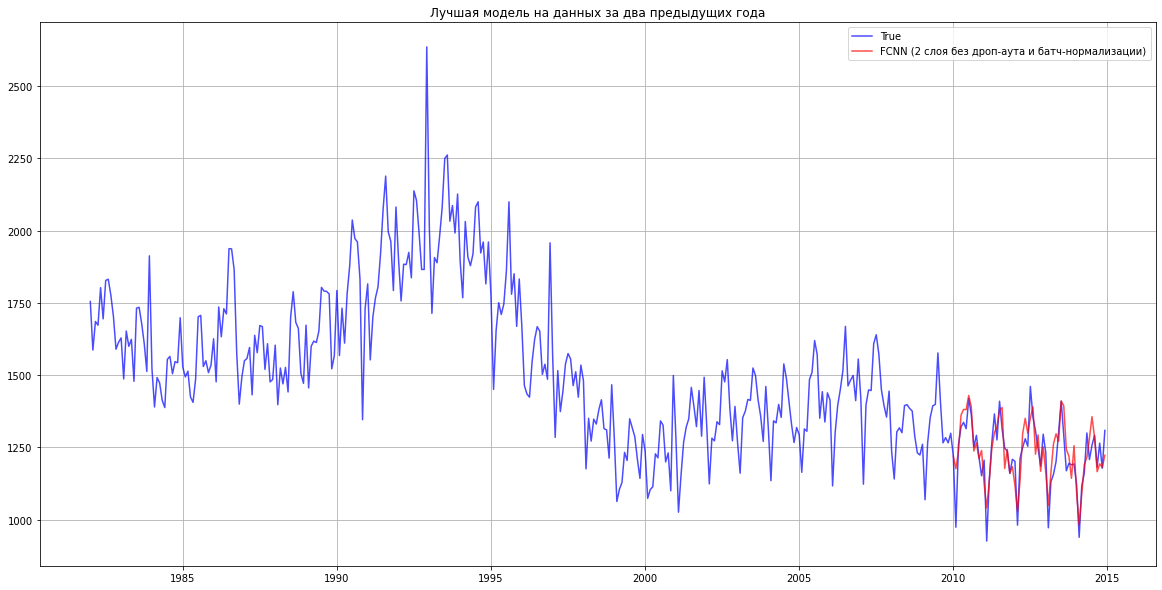

In [46]:
plt.figure(figsize=(20,10)) 
plt.plot(time_series['Date'], time_series['NumCases'], color='b', alpha=0.7, label="True")
plt.plot(time_series['Date'][-60:], time_series['NumCases_predict'][-60:], color='r', alpha=0.7, label="FCNN (2 слоя без дроп-аута и батч-нормализации)")
plt.title('Лучшая модель на данных за два предыдущих года')
plt.grid()
plt.legend()
plt.show()

**RMSE: 63.468422**
#### Быстродействие

In [47]:
spans = []
with torch.no_grad():
    for i in range(101):
        start = time.time()
        best_model_24months(torch.from_numpy(X_test).to(device)).numpy()
        finish = time.time()
        spans.append(finish - start)

spans = np.asarray(spans[1:])
print('Mean predict time:', spans.mean(), 'Std:', spans.std(ddof=1))

Mean predict time: 0.00019400596618652344 Std: 0.0009213777725007539


## 3 Результаты
 - Лучшей моделью, предсказывающей количество убийств на следующий месяц по данным за предыдущий год, оказалась полносвязная нейронная сеть с двумя слоями без дроп-аута и батч-нормализации. Значение метрики RMSE на тестовой выборке: 70.164116. Время обучения на 2092 эпохах - 32 секунды. Время предсказания на тестовой выборе - 0.0002 секунды.
 - Лучшей моделью, предсказывающей количество убийств на следующий месяц по данным за предыдущий год, оказалась полносвязная нейронная сеть с двумя слоями без дроп-аута и батч-нормализации. Значение метрики RMSE на тестовой выборке: 63.468422. Время обучения на 1803 эпохах - 19.6 секунд. Время предсказания на тестовой выборе - 0.0002 секунды.


Hardware: 2 ядра процессора Intel Xeon E5-2699 v4 2.20 ГГц, 12ГБ оперативной памяти